# Challenge #2: Arithmetic

## The purpose of this challenge is to test candidates’ basic knowledge of Bayesian statistics and arithmetic skills. Using the data set provided, please write your own Bayesian algorithm to categorize map_publisher to channel for the given dataset.  

### Author : Rishi Sankineni 

### Step 1: Import all the necessary Python modules.

In [29]:
import pandas as pd 
import wordninja 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Load the publisher channel mapping dataset using Pandas and read it into a DataFrame.
pub_chan_map = pd.read_csv("publisher_channel_mapping.csv",low_memory=False) 

In [21]:
# display first 10 rows of our dataset to see how the data looks like.
pub_chan_map.head(10)

,map_publisher,channel
0,4music,paidtelevision
1,4seven,paidtelevision
2,5paidtelevision,paidtelevision
3,5paidtelevisionplus1,paidtelevision
4,5select,paidtelevision
5,5spike,paidtelevision
6,5star,paidtelevision
7,5starplus1,paidtelevision
8,5tv,paidtelevision
9,5tvplus1,paidtelevision


In [5]:
# Since channel is our class label, let's look at its distribution.
pub_chan_map["channel"].value_counts()

paidtelevision    472
paidradio          66
paiddisplay         5
paidsearch          3
paidoutofhome       2
paidvideo           1
paidsocial          1
Name: channel, dtype: int64

### Step 2: Data Preprocessing 

### 1) Split text without spaces into list of words. We're mainly interested in splitting the text data in the map_publisher column, because there are no unique values which can be fed to our Bayesian(Naive Bayes) algorithm. For instance, let's say our input is "5starplus1" we'd like to split such text into list of words and get: ['5', 'star', 'plus', '1']. How do we do this efficiently? Well, we could probabilistically split concatenated words using NLP based on English Wikipedia unigram frequencies. We'd be using Wordninja, a Python package to perform this task.

#### Wordninja GitHub repo: https://github.com/keredson/wordninja

In [10]:
# Here's how we split the nonspaced text using wordninja.
import wordninja
word_split = wordninja.split('5starplus1')
word_split

['5', 'star', 'plus', '1']

### As you can see, the result for the above unspaced text is a "list" rather than a "string". So, we've to join those list of words to form a sentence. 

In [9]:
# this is how we convert a list of words into a sentence in Python.
print (' '.join(word for word in word_split))

5 star plus 1


### Okay, now let's apply the above logic to our entire dataset. Please note that we'd also be excluding the digits from our text, because I think the digits in the map_publisher field aren't that useful for our Bayesian model. So, our preprocessed text would only contain text.

In [22]:
## split the text in the "map_publisher" column and save it into a new column in our dataframe.
pub_chan_map["new_map_publisher"] = pub_chan_map['map_publisher'].apply(lambda x: wordninja.split(x))
pub_chan_map["new_map_publisher"] = pub_chan_map['new_map_publisher'].apply(lambda x: ' ' .join(word for word in x if not word.isdigit()))

In [23]:
# split the text in the "channel" column and save it into a new column in our dataframe.
pub_chan_map["new_channel"] = pub_chan_map["channel"].apply(lambda x: wordninja.split(x))
pub_chan_map["new_channel"] = pub_chan_map["new_channel"].apply(lambda x: ' '.join(word for word in x))

### This is how our new dataset looks like:

In [24]:
pub_chan_map.head(10)
# the last 2 columns were generated from our preprocessing step.

,map_publisher,channel,new_map_publisher,new_channel
0,4music,paidtelevision,music,paid television
1,4seven,paidtelevision,seven,paid television
2,5paidtelevision,paidtelevision,paid television,paid television
3,5paidtelevisionplus1,paidtelevision,paid television plus,paid television
4,5select,paidtelevision,select,paid television
5,5spike,paidtelevision,spike,paid television
6,5star,paidtelevision,star,paid television
7,5starplus1,paidtelevision,star plus,paid television
8,5tv,paidtelevision,tv,paid television
9,5tvplus1,paidtelevision,tv plus,paid television


### Let's drop our old columns and only use the columns which were generated from our preprocessing step

In [25]:
pub_chan_map.drop(['map_publisher','channel'], axis = 1, inplace=True) # drop the old columns

In [26]:
pub_chan_map.head(10) # this is how our new dataset looks like.

,new_map_publisher,new_channel
0,music,paid television
1,seven,paid television
2,paid television,paid television
3,paid television plus,paid television
4,select,paid television
5,spike,paid television
6,star,paid television
7,star plus,paid television
8,tv,paid television
9,tv plus,paid television


## Step 3 : Build a text categorization/classification model.

## 1) Imbalanced Classes

### We see that the number of media channels per publisher is imbalanced. Advertisers are more biased towards Paid television and Paid radio.

### Background: When we encounter such problems, we are bound to have difficulties solving them with standard algorithms. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. For some cases, such as  cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

### Takeaway: However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, we will leave it as it is.

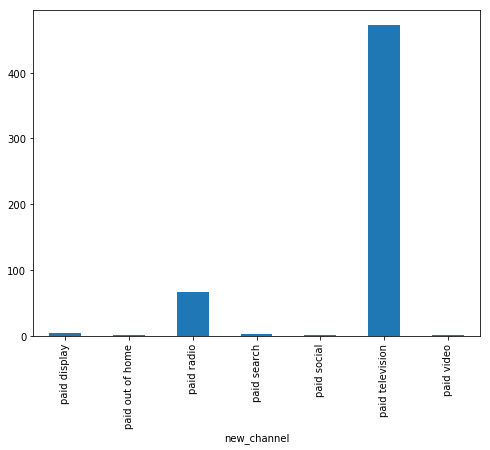

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
pub_chan_map.groupby('new_channel').new_map_publisher.count().plot.bar(ylim=0)
plt.show()

## 2) Data to vectors

### Now we'll convert each publisher, represented as a string, into a vector that machine learning models can understand.

### Now we need to transform the probability we want to calculate into something that can be calculated using word frequencies. For this, we will use some basic properties of probabilities, and Bayes’ Theorem. 

### Doing that requires essentially three steps, in the bag-of-words model:

##### a) counting how many times does a word occur in each publisher (term frequency)
##### b) weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
##### c) normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

In [30]:
## We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of our publishers:
## Hyperparameters: sublinear_df, min_df, norm, encoding, ngram_range.
# sublinear_df is set to True to use a logarithmic form for frequency.
# min_df is the minimum numbers of documents a word must be present in to be kept.
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(pub_chan_map.new_map_publisher).toarray()
labels = pub_chan_map.new_channel
features.shape

(550, 54)

### Now, each of 550 media publishers is represented by 54 features, representing the tf-idf score for different unigrams and bigrams.

## Takeaways:

### To train our bayesian classifier, we first transformed the “publisher_map” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors.

### After having this vector representations of the text we can train our bayesian classifier to learn unseen “publishers” and predict the “media channel” on which they fall.


----

# 3) Naive Bayes Classifier

### After all the above data transformation, now that we have all the features and labels, it is time to train our bayesian classifier. We will be using the Naive Bayes Classifier. The one most suitable for word counts is the multinomial variant of Naive Bayes.

### Multinomial Naive Bayes: "Feature vectors represent the frequencies with which certain events have been generated by a multinomial distribution. This is the event model typically used for document classification."

In [64]:
## 75-25 train v/s test split.
X_train, X_test, y_train, y_test = train_test_split(pub_chan_map['new_map_publisher'], pub_chan_map['new_channel'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

#### So, as requested, the test size is 25% of the entire dataset (138 publishers out of total 550), and the training is the rest (412 out of 550).

In [65]:
print (len(X_train), len(X_test), len(y_train) + len(y_test))

412 138 550


### 10-fold Cross-validation: 

### "A common practice is to partition the training set again, into smaller subsets; for example, 10 equally sized subsets. Then we train the model on nine parts, and compute accuracy on the last part (called "validation set"). Repeated ten time times (taking different part for evaluation each time), we get a sense of model "stability". If the model gives wildly different scores for different subsets, it's a sign something is wrong (bad data, or bad model variance). Go back, analyze errors, re-check input data for garbage, re-check data cleaning."

In [66]:
from sklearn.model_selection import cross_val_score
models = [
    MultinomialNB(),
]
CV = 10 # 10-fold
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

### Model accuracy: 96%. The scores are already high here, but how could we improve this model in the future?

1) Get more training data with a balanced class distribution to overcome low model complexity. Our dataset has a pretty high class imbalance ratio, so 
the model may not be able to generalize well to new publishers from a media channel with a lower class distribution.

2) Try different text preprocessing techniques like lemmatization, stemming, stopwords removal to generate more features.

In [67]:
cv_df.groupby('model_name').accuracy.mean()

model_name
MultinomialNB    0.961134
Name: accuracy, dtype: float64

### 96% accuracy?? Did the model overfit? I'd say it's very unlikely our model would've overfit because Naive-Bayes is an example of high bias - low variance classifier ( aka simple and stable, not prone to overfitting) and we've also performed 10-fold cross-validation to avoid it.

----

# 4) Being Naive

### Okay, let's see if our model is able to map a new(or unseen) publisher to a media channel. 

### So here comes the Naive part: we assume that every word in a sentence is independent of the other ones. This means that we’re no longer looking at entire sentences, but rather at individual words. So for our purposes, “los angeles city network” is the same as “city los angeles network” and “network angeles city los”.

### Prediction

In [98]:
print(clf.predict(count_vect.transform(["los angeles city network"])))

['paid radio']


In [99]:
print(clf.predict(count_vect.transform(["city los angeles network"])))

['paid radio']


#### Finally, we print out the classification report for each class: 

Only paid television has an f1, precision, recall scores because of our class distribution being so skewed towards it.

In [84]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
predictions = clf.predict(count_vect.transform(y_test))
print(classification_report(y_test, predictions))

                  precision    recall  f1-score   support

    paid display       0.00      0.00      0.00         1
paid out of home       0.00      0.00      0.00         1
      paid radio       0.00      0.00      0.00        15
 paid television       0.88      1.00      0.93       121

       micro avg       0.88      0.88      0.88       138
       macro avg       0.22      0.25      0.23       138
    weighted avg       0.77      0.88      0.82       138

